# Hybrid EV Spare Parts Demand Classification
_Final consolidated script (ANN + benchmarks) with all edits applied_


# Imports & Reproducibility


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import sys
import subprocess
import platform

def _ensure_import(module_name, pip_name=None):
    try:
        return __import__(module_name)
    except ModuleNotFoundError:
        pkg = pip_name or module_name
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg, '-q'])
        return __import__(module_name)

_ensure_import('seaborn', 'seaborn')
_ensure_import('sklearn', 'scikit-learn')
_ensure_import('joblib', 'joblib')
_ensure_import('numpy', 'numpy')
_ensure_import('pandas', 'pandas')
_ensure_import('matplotlib', 'matplotlib')
system = platform.system()
machine = platform.machine().lower()
tf_pkg = 'tensorflow'
if system == 'Windows':
    tf_pkg = 'tensorflow-cpu'
elif system == 'Darwin' and 'arm' in machine:
    tf_pkg = 'tensorflow-macos'
_ensure_import('tensorflow', tf_pkg)



import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"

import json
import itertools
import hashlib
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupShuffleSplit, GroupKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, f1_score
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.utils.class_weight import compute_class_weight

import joblib

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Seeds
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)



# Config


In [ ]:
# Exclude 'part' from features (still used for grouping)
DROP_PART = True

# ANN hyperparameter grid (exhaustive but small)
GRID = {
    'num_layers':    [1, 2, 3],
    'units':         [16, 32],
    'dropout_rate':  [0.0, 0.2],
    'l2_reg':        [0.0, 1e-4],
    'learning_rate': [1e-3, 3e-3, 1e-2]
}

# Small grids for the classical models
GRIDS_CLASSIC = {
    "svc_rbf": {"C": [1.0, 3.0], "gamma": ["scale", "auto"]},
    "logreg":  {"C": [0.3, 1.0, 3.0], "solver": ["lbfgs"], "max_iter": [2000]},
    "et":      {"n_estimators": [200, 400], "max_depth": [None, 20]},
    "sgd":     {"loss": ["log_loss"], "alpha": [1e-4, 1e-3], "max_iter": [2000], "random_state": [SEED]},
    "lda":     {"solver": ["svd"]},
}

MODEL_ZOO = {
    "svc_rbf": {
        "label": "SVC (RBF)",
        "factory": lambda p: SVC(**p),
        "style": "scale",
    },
    "logreg": {
        "label": "LogisticRegression",
        "factory": lambda p: LogisticRegression(multi_class="multinomial", **p),
        "style": "scale",
    },
    "et": {
        "label": "ExtraTrees",
        "factory": lambda p: ExtraTreesClassifier(random_state=SEED, n_jobs=-1, **p),
        "style": "tree",
    },
    "sgd": {
        "label": "SGDClassifier (log_loss)",
        "factory": lambda p: SGDClassifier(**p),
        "style": "scale",
    },
    "lda": {
        "label": "LinearDiscriminantAnalysis",
        "factory": lambda p: LDA(**p),
        "style": "scale",
    },
}
MODEL_KEYS = ["svc_rbf", "logreg", "et", "sgd", "lda"]



# Load & clean


In [ ]:
# Support environment override, then common relative paths
data_env = os.environ.get("DEMAND_DATA_PATH", "").strip()
candidates = [Path(p) for p in [data_env] if p] + [
    Path("data") / "demand.csv",
    Path("..") / "data" / "demand.csv",
]
file_path = None
for p in candidates:
    if p.exists():
        file_path = p
        break
if file_path is None:
    raise FileNotFoundError("Could not find demand.csv. Set DEMAND_DATA_PATH or place the file in data/ or ../data/.")

df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()
print("Using file:", file_path.resolve())
print("Initial shape:", df.shape)

# Drop exact duplicates
dup_count = df.duplicated().sum()
if dup_count:
    print(f"Dropping {dup_count} duplicate rows")
    df = df.drop_duplicates().reset_index(drop=True)



# Feature schema


In [ ]:
# Keep the exact strings as present in your CSV.
cat_cols = [
    'car type',
    'made in',
    'original/imitator',
    'new\\used',
    'selling location',
    'service location (repair shop/automotive company',
    'part'  # identity-like
]
num_all = [
    'number of cars in jordan',
    'car age',
    'failure rate',
    'price of the car',
    'repair or replacement cost',
    'critically',                         # ensure this matches the CSV header
    'on line price',
    'car total maintenance cost average'  # numeric
]

required_cols = cat_cols + num_all + ['demand']
missing_cols = [c for c in required_cols if c not in df.columns]
if missing_cols:
    raise ValueError(f"Missing expected columns: {missing_cols}")

cat_cols_effective = [c for c in cat_cols if not (DROP_PART and c == 'part')]
X_all = df[cat_cols_effective + num_all].copy()
groups_all = df['part'].astype(str)  # for grouped splits

# Numeric columns that benefit from log1p
skewed_cols = [
    'on line price',
    'number of cars in jordan',
    'failure rate',
    'repair or replacement cost',
    'critically',
    'price of the car'
]
other_num_cols = [c for c in num_all if c not in skewed_cols]



# Helper functions


In [ ]:
def compute_thresholds_from_train(demand_series, q_low=0.33, q_high=0.66):
    q = demand_series.quantile([q_low, q_high])
    return float(q.loc[q_low]), float(q.loc[q_high])

def bin_with_thresholds(demand_series, low_thr, high_thr):
    # Note: pd.cut ties at exact quantiles fall into the higher bin by default
    return pd.cut(
        demand_series,
        bins=[-np.inf, low_thr, high_thr, np.inf],
        labels=[0, 1, 2]
    ).astype(int)

def make_preprocessor(style: str) -> ColumnTransformer:
    """Return a ColumnTransformer adapted to the model style."""
    if style == "scale":
        num_skew = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('log1p', FunctionTransformer(np.log1p, validate=False)),
            ('scaler', StandardScaler())
        ])
        num_plain = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
    elif style == "tree":
        num_skew = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('log1p', FunctionTransformer(np.log1p, validate=False))
        ])  # no scaler
        num_plain = Pipeline([
            ('imputer', SimpleImputer(strategy='median'))
        ])
    else:
        raise ValueError(f"Unknown preprocessor style: {style}")

    # OHE dense for compatibility across versions
    try:
        cat = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])
    except TypeError:
        cat = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
        ])

    return ColumnTransformer(
        transformers=[
            ('num_skew', num_skew,   skewed_cols),
            ('num',      num_plain,  other_num_cols),
            ('cat',      cat,        cat_cols_effective)
        ],
        remainder='drop'
    )

def build_ann(input_dim, num_layers, units, dropout_rate, l2_reg, learning_rate, num_classes=3):
    tf.keras.backend.clear_session()
    model = Sequential()
    reg = regularizers.l2(l2_reg) if l2_reg and l2_reg > 0 else None
    for i in range(num_layers):
        if i == 0:
            model.add(Dense(units, activation='relu', kernel_regularizer=reg, input_shape=(input_dim,)))
        else:
            model.add(Dense(units, activation='relu', kernel_regularizer=reg))
        if dropout_rate and dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def grid_dict_product(grid):
    keys = list(grid.keys())
    for values in itertools.product(*(grid[k] for k in keys)):
        yield dict(zip(keys, values))

def hash_rows(df_like):
    """Create a stable hash per row using the actual feature columns used by the model."""
    str_df = df_like.copy()
    for c in str_df.columns:
        if pd.api.types.is_float_dtype(str_df[c]) or pd.api.types.is_integer_dtype(str_df[c]):
            str_df[c] = str_df[c].astype(float).map(lambda x: f"{x:.12g}")
        else:
            str_df[c] = str_df[c].astype(str)
    concat = str_df.apply(lambda r: '||'.join(r.values.astype(str)), axis=1)
    return concat.map(lambda s: hashlib.md5(s.encode('utf-8')).hexdigest())



# Basic dataset profile


In [ ]:
print("n_rows:", len(df), "n_unique_parts:", df['part'].nunique())
print("Rows per part (describe):")
print(df['part'].value_counts().describe())



# Per-part purity (leakage hint)


In [ ]:
tmp_low, tmp_high = compute_thresholds_from_train(df['demand'])  # approximate
tmp_y = bin_with_thresholds(df['demand'], tmp_low, tmp_high)
part_class_counts = pd.crosstab(df['part'], tmp_y)
part_purity = part_class_counts.max(axis=1) / part_class_counts.sum(axis=1)
print("\nPer-part purity, top 10:")
print(part_purity.sort_values(ascending=False).head(10))
print(f"Mean per-part purity: {part_purity.mean():.4f}")



# Outer grouped train/test split


In [ ]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx, test_idx = next(gss.split(X_all, None, groups=groups_all))

X_train_raw, X_test_raw = X_all.iloc[train_idx], X_all.iloc[test_idx]
groups_train, groups_test = groups_all.iloc[train_idx], groups_all.iloc[test_idx]
demand_train, demand_test = df['demand'].iloc[train_idx], df['demand'].iloc[test_idx]

# Create labels using thresholds from TRAIN ONLY
low_thr, high_thr = compute_thresholds_from_train(demand_train)
print(f"\nTrain-only thresholds: 33%={low_thr:.6f}, 66%={high_thr:.6f}")
y_train = bin_with_thresholds(demand_train, low_thr, high_thr)
y_test  = bin_with_thresholds(demand_test,  low_thr, high_thr)

# Class distribution check
print("\nClass distribution (train):")
print(y_train.value_counts().sort_index())
print("Class distribution (test):")
print(y_test.value_counts().sort_index())



# Row-hash overlap audit


In [ ]:
train_hash = hash_rows(X_train_raw)
test_hash  = hash_rows(X_test_raw)
overlap = set(train_hash).intersection(set(test_hash))
print(f"\nRow-hash overlap between train and test using model features: {len(overlap)} rows")
if len(overlap) > 0:
    print("WARNING: Identical feature rows detected across train and test. Investigate potential duplicates.")



# ANN grid search on grouped inner split


In [ ]:
# Carve inner validation from outer training (grouped)
inner_gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
inner_tr_idx, inner_val_idx = next(inner_gss.split(X_train_raw, y_train, groups=groups_train))
X_inner_tr_raw = X_train_raw.iloc[inner_tr_idx]
X_inner_val_raw = X_train_raw.iloc[inner_val_idx]
y_inner_tr = y_train.iloc[inner_tr_idx]
y_inner_val = y_train.iloc[inner_val_idx]

# Fit ONE preprocessor for the inner split and reuse its matrices across grid combos
pre_gs = make_preprocessor(style="scale")
X_inner_tr = pre_gs.fit_transform(X_inner_tr_raw)
X_inner_val = pre_gs.transform(X_inner_val_raw)
input_dim_inner = X_inner_tr.shape[1]

best_cfg = None
best_val_f1 = -np.inf
best_history = None

total_combos = int(np.prod([len(v) for v in GRID.values()]))
print(f"\nStarting ANN exhaustive grid search over {total_combos} combinations...")
for idx, cfg in enumerate(grid_dict_product(GRID), start=1):
    print(f"Config {idx}/{total_combos}: {cfg}")
    model = build_ann(
        input_dim=input_dim_inner,
        num_layers=cfg['num_layers'],
        units=cfg['units'],
        dropout_rate=cfg['dropout_rate'],
        l2_reg=cfg['l2_reg'],
        learning_rate=cfg['learning_rate'],
        num_classes=3
    )
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=0)

    history = model.fit(
        X_inner_tr, y_inner_tr,
        epochs=200,
        validation_data=(X_inner_val, y_inner_val),
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )

    y_val_pred = np.argmax(model.predict(X_inner_val, verbose=0), axis=1)
    f1 = f1_score(y_inner_val, y_val_pred, average='macro')
    if f1 > best_val_f1:
        best_val_f1 = f1
        best_cfg = cfg
        best_history = history

print("\nBest ANN grid configuration (inner grouped val macro F1):", round(best_val_f1, 4))
print(best_cfg)



# Retrain ANN on full training set with grouped early stopping


In [ ]:
# Fit ONE preprocessor on the full outer training set
preprocessor = make_preprocessor(style="scale")
X_train_proc = preprocessor.fit_transform(X_train_raw)
X_test_proc  = preprocessor.transform(X_test_raw)
input_dim = X_train_proc.shape[1]

# Early-stopping split by indexing the already-transformed matrix
inner_tr_idx2, inner_val_idx2 = next(inner_gss.split(X_train_raw, y_train, groups=groups_train))
X_tr2 = X_train_proc[inner_tr_idx2]
X_val2 = X_train_proc[inner_val_idx2]
y_tr2, y_val2 = y_train.iloc[inner_tr_idx2], y_train.iloc[inner_val_idx2]

model = build_ann(
    input_dim=input_dim,
    num_layers=best_cfg['num_layers'],
    units=best_cfg['units'],
    dropout_rate=best_cfg['dropout_rate'],
    l2_reg=best_cfg['l2_reg'],
    learning_rate=best_cfg['learning_rate'],
    num_classes=3
)

# Optional class weights if imbalance exists
class_weight = None
train_counts = y_tr2.value_counts().sort_index()
if train_counts.min() / train_counts.max() < 0.6:
    cw = compute_class_weight(class_weight='balanced', classes=np.array([0,1,2]), y=y_tr2)
    class_weight = {i: w for i, w in enumerate(cw)}
    print("Using class weights:", class_weight)

early_stop_final = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr_final  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=0)

history = model.fit(
    X_tr2, y_tr2,
    epochs=200,
    validation_data=(X_val2, y_val2),
    callbacks=[early_stop_final, reduce_lr_final],
    verbose=0,
    class_weight=class_weight
)



# Plots


In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.ylim(0, 1)
plt.title('Model Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.tight_layout()
plt.savefig('training_validation_curves.png', dpi=300, bbox_inches='tight')
plt.show()



# Test evaluation (unseen parts)


In [ ]:
y_pred_proba = model.predict(X_test_proc, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = y_test.to_numpy()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title('Confusion Matrix (counts) - grouped split (unseen parts)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nClassification Report (grouped split: unseen parts):")
print(classification_report(y_true, y_pred, zero_division=0))
print(f"Test Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Macro F1:      {f1_score(y_true, y_pred, average='macro'):.4f}")



# Grouped CV with per-fold thresholds & preprocessing


In [ ]:
num_folds = 5
gkf = GroupKFold(n_splits=num_folds)

acc_per_fold, f1_per_fold, loss_per_fold = [], [], []
fold_no = 1
for tr_idx, val_idx in gkf.split(X_all, None, groups=groups_all):
    X_tr_raw, X_val_raw = X_all.iloc[tr_idx], X_all.iloc[val_idx]
    demand_tr, demand_val = df['demand'].iloc[tr_idx], df['demand'].iloc[val_idx]

    # Fold-specific thresholds from training portion
    low_f, high_f = compute_thresholds_from_train(demand_tr)
    y_tr_f = bin_with_thresholds(demand_tr, low_f, high_f)
    y_val_f = bin_with_thresholds(demand_val, low_f, high_f)

    pre_fold = make_preprocessor(style="scale")
    X_tr = pre_fold.fit_transform(X_tr_raw)
    X_val = pre_fold.transform(X_val_raw)

    model_fold = build_ann(
        input_dim=X_tr.shape[1],
        num_layers=best_cfg['num_layers'],
        units=best_cfg['units'],
        dropout_rate=best_cfg['dropout_rate'],
        l2_reg=best_cfg['l2_reg'],
        learning_rate=best_cfg['learning_rate'],
        num_classes=3
    )

    hist_f = model_fold.fit(
        X_tr, y_tr_f,
        epochs=200,
        validation_data=(X_val, y_val_f),
        callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
                   ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=0)],
        verbose=0
    )

    loss, acc = model_fold.evaluate(X_val, y_val_f, verbose=0)
    y_val_pred = np.argmax(model_fold.predict(X_val, verbose=0), axis=1)
    f1 = f1_score(y_val_f, y_val_pred, average='macro')

    print(f"Fold {fold_no}: Acc={acc*100:.2f}% | Loss={loss:.4f} | MacroF1={f1:.4f}")
    acc_per_fold.append(acc * 100); f1_per_fold.append(f1); loss_per_fold.append(loss)
    fold_no += 1

print('\n' + '-'*72)
print('Grouped CV summary (unseen parts each fold):')
print(f"Accuracy: mean {np.mean(acc_per_fold):.2f}%  (Â± {np.std(acc_per_fold):.2f})")
print(f"Macro F1: mean {np.mean(f1_per_fold):.4f} (Â± {np.std(f1_per_fold):.4f})")
print(f"Loss:     mean {np.mean(loss_per_fold):.4f}")
print('-'*72)



# Single-feature leakage audit (grouped CV)


In [ ]:
def single_feature_cv_score(feature_name):
    # Build a tiny pipeline: transform only this feature, then multinomial logistic regression
    if feature_name in cat_cols_effective:
        try:
            ohe = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ])
        except TypeError:
            ohe = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
            ])
        pipe = Pipeline([('ohe', ohe),
                         ('clf', LogisticRegression(max_iter=2000, multi_class='multinomial'))])
        X_feat = df[[feature_name]].astype(str)
    else:
        steps = []
        steps.append(('imputer', SimpleImputer(strategy='median')))
        if feature_name in skewed_cols:
            steps.append(('log1p', FunctionTransformer(np.log1p, validate=False)))
        steps.append(('scaler', StandardScaler()))
        steps.append(('clf', LogisticRegression(max_iter=2000, multi_class='multinomial')))
        pipe = Pipeline(steps)
        X_feat = df[[feature_name]].copy()

    f1_scores = []
    for tr_idx, val_idx in gkf.split(X_all, None, groups=groups_all):
        d_tr = df['demand'].iloc[tr_idx]; d_val = df['demand'].iloc[val_idx]
        low_f, high_f = compute_thresholds_from_train(d_tr)
        y_tr_f = bin_with_thresholds(d_tr, low_f, high_f)
        y_val_f = bin_with_thresholds(d_val, low_f, high_f)

        X_tr_f = X_feat.iloc[tr_idx]; X_val_f = X_feat.iloc[val_idx]
        pipe.fit(X_tr_f, y_tr_f)
        y_val_pred = pipe.predict(X_val_f)
        f1_scores.append(f1_score(y_val_f, y_val_pred, average='macro'))

    return np.mean(f1_scores)

features_to_audit = cat_cols_effective + num_all
audit_results = []
print("\nRunning single-feature leakage audit (grouped CV, macro F1 per feature)...")
for feat in features_to_audit:
    score = single_feature_cv_score(feat)
    audit_results.append((feat, score))
audit_results.sort(key=lambda x: x[1], reverse=True)
print("Top 10 features by single-feature macro F1:")
for name, sc in audit_results[:10]:
    print(f"{name:45s} {sc:.4f}")

suspicious = [(n, s) for n, s in audit_results if s >= 0.99]
if suspicious:
    print("\nWARNING: These features alone achieve near-perfect classification under grouped CV:")
    for n, s in suspicious:
        print(f"  - {n}: macro F1 {s:.4f}")
    print("Review whether they encode target information directly or leak future knowledge.")



# Save tuned ANN model, preprocessor, and thresholds


In [ ]:
model.save("demand_clf.keras")
with open("label_thresholds.txt", "w") as f:
    f.write(f"{low_thr},{high_thr}\n")

joblib.dump(preprocessor, "preprocessor.joblib")
with open("label_metadata.json", "w") as f:
    json.dump({
        "low_thr": low_thr,
        "high_thr": high_thr,
        "class_order": [0, 1, 2],
        "seed": int(SEED),
        "cat_cols_effective": cat_cols_effective,
        "num_all": num_all,
        "skewed_cols": skewed_cols,
        "other_num_cols": other_num_cols
    }, f, indent=2)

print("\nSaved tuned ANN model to demand_clf.keras")
print("Saved train-only label thresholds to label_thresholds.txt")
print("Saved preprocessor to preprocessor.joblib and label metadata to label_metadata.json")
print("Best ANN configuration:", GRID if best_cfg is None else best_cfg)



# Classical models benchmark (top 5)


In [ ]:
def fit_select_on_inner_classic(model_key, X_tr_raw, y_tr, groups_tr):
    """Carve an inner grouped validation split from outer-train to select hyperparams.
       Fit ONE preprocessor for that model style and reuse its matrices across param combos."""
    inner = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    inner_tr_idx, inner_val_idx = next(inner.split(X_tr_raw, y_tr, groups=groups_tr))

    X_inner_tr_raw = X_tr_raw.iloc[inner_tr_idx]
    X_inner_val_raw = X_tr_raw.iloc[inner_val_idx]
    y_inner_tr = y_tr.iloc[inner_tr_idx]
    y_inner_val = y_tr.iloc[inner_val_idx]

    spec = MODEL_ZOO[model_key]
    grid = GRIDS_CLASSIC[model_key]
    style = spec["style"]

    pre = make_preprocessor(style)
    X_inner_tr = pre.fit_transform(X_inner_tr_raw)
    X_inner_val = pre.transform(X_inner_val_raw)

    best_f1 = -np.inf
    best_params = None

    for params in grid_dict_product(grid):
        est = spec["factory"](params)
        est.fit(X_inner_tr, y_inner_tr)
        y_val_pred = est.predict(X_inner_val)
        f1 = f1_score(y_inner_val, y_val_pred, average="macro")
        if f1 > best_f1:
            best_f1 = f1
            best_params = params

    return best_params, best_f1

records = []

for key in MODEL_KEYS:
    label = MODEL_ZOO[key]["label"]
    print(f"\n=== {label} ({key}) ===")

    # Hyperparameter selection on a grouped inner split
    best_params, inner_f1 = fit_select_on_inner_classic(key, X_train_raw, y_train, groups_train)
    print(f"Selected params: {best_params} | Inner macro F1={inner_f1:.4f}")

    # Refit preprocessor on full outer-train, then train and evaluate
    pre = make_preprocessor(MODEL_ZOO[key]["style"])
    X_train_cls = pre.fit_transform(X_train_raw)
    X_test_cls  = pre.transform(X_test_raw)

    est = MODEL_ZOO[key]["factory"](best_params)
    est.fit(X_train_cls, y_train)

    y_pred_cls = est.predict(X_test_cls)
    acc = accuracy_score(y_test, y_pred_cls)
    f1m = f1_score(y_test, y_pred_cls, average="macro")

    print(f"Test Accuracy={acc:.4f} | Test Macro F1={f1m:.4f}")
    print(classification_report(y_test, y_pred_cls, zero_division=0))

    records.append(
        {
            "key": key,
            "model": label,
            "best_params": best_params,
            "inner_macro_f1": round(inner_f1, 4),
            "test_accuracy": round(acc, 4),
            "test_macro_f1": round(f1m, 4),
        }
    )



# Summary of classical models


In [ ]:
results = pd.DataFrame.from_records(records)
results_sorted = results.sort_values(
    ["test_macro_f1", "test_accuracy"], ascending=False
).reset_index(drop=True)

print("\n=== Ranked results (outer test) ===")
print(results_sorted[["model", "test_macro_f1", "test_accuracy", "inner_macro_f1", "best_params"]])

results_sorted.to_csv("model_benchmark_results_top5.csv", index=False)
print("\nSaved benchmark table to model_benchmark_results_top5.csv")


# The code after fixing the figure

Using file: \\oochcfs10\users\oaliyaeesh\DOWNLOADS\hev-spareparts-ml\data\demand.csv
Initial shape: (7652, 16)
Dropping 60 duplicate rows
n_rows: 7592 n_unique_parts: 36
Rows per part (describe):
count     36.000000
mean     210.888889
std       59.474738
min       40.000000
25%      188.000000
50%      188.000000
75%      235.500000
max      340.000000
Name: count, dtype: float64

Per-part purity, top 10:
part
2     1.000000
1     0.900000
29    0.829787
6     0.796748
24    0.739130
36    0.702128
18    0.659574
20    0.609524
10    0.608696
15    0.595745
dtype: float64
Mean per-part purity: 0.5293

Train-only thresholds: 33%=1.800064, 66%=5.589000

Class distribution (train):
demand
0    1917
1    1861
2    1942
Name: count, dtype: int64
Class distribution (test):
demand
0    636
1    632
2    604
Name: count, dtype: int64

Row-hash overlap between train and test using model features: 0 rows

Starting ANN exhaustive grid search over 72 combinations...
Config 1/72: {'num_layers': 1,

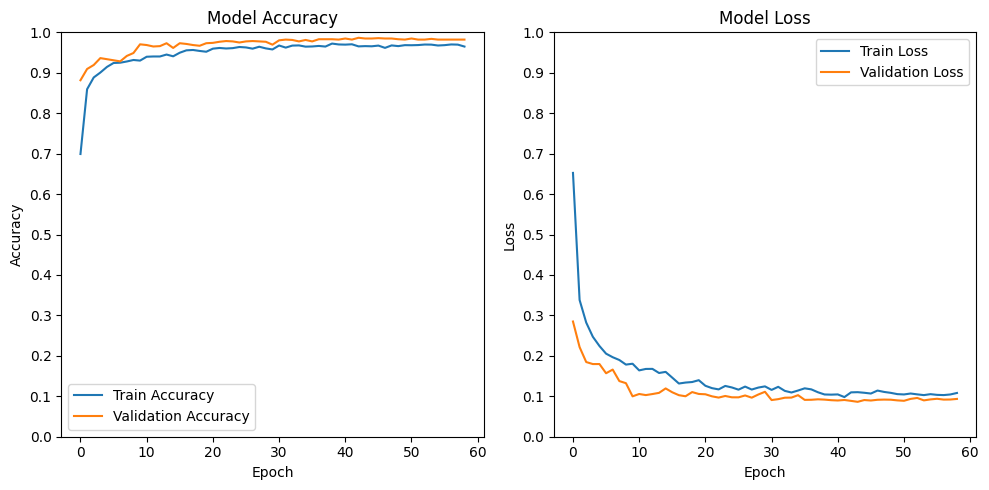

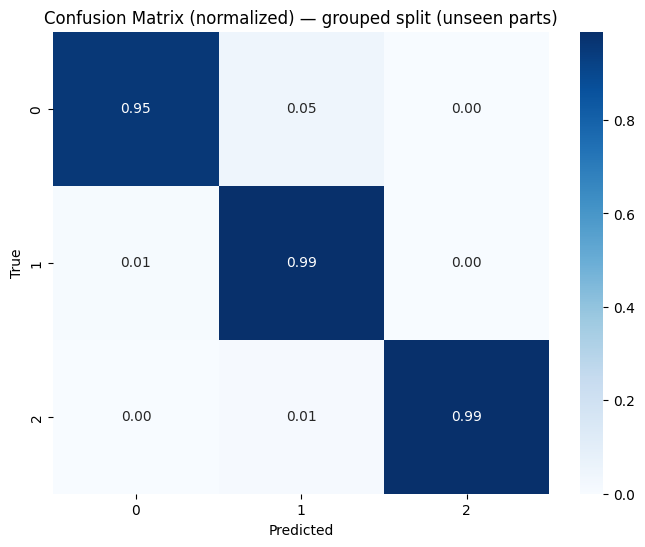


Classification Report (grouped split: unseen parts):
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       636
           1       0.94      0.99      0.97       632
           2       1.00      0.99      0.99       604

    accuracy                           0.98      1872
   macro avg       0.98      0.98      0.98      1872
weighted avg       0.98      0.98      0.98      1872

Test Accuracy: 0.9765
Macro F1:      0.9768
Fold 1: Acc=99.34% | Loss=0.0591 | MacroF1=0.9934
Fold 2: Acc=99.35% | Loss=0.0510 | MacroF1=0.9924
Fold 3: Acc=99.73% | Loss=0.0433 | MacroF1=0.9975
Fold 4: Acc=99.60% | Loss=0.0493 | MacroF1=0.9958
Fold 5: Acc=98.87% | Loss=0.0545 | MacroF1=0.9882

------------------------------------------------------------------------
Grouped CV summary (unseen parts each fold):
Accuracy: mean 99.38%  (Â± 0.30)
Macro F1: mean 0.9935 (Â± 0.0032)
Loss:     mean 0.0515
---------------------------------------------------------------

: 

In [ ]:
# ================================================================
# Hybrid EV Spare Parts Demand Classification
# Final consolidated script (ANN + benchmarks) with y-axis fixed to [0, 1]
# ================================================================

# ===================== Imports & Reproducibility =====================
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"

import json
import itertools
import hashlib
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupShuffleSplit, GroupKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, f1_score
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.utils.class_weight import compute_class_weight

import joblib

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Seeds
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ===================== Config =====================
# Exclude 'part' from features (still used for grouping)
DROP_PART = True

# ANN hyperparameter grid (exhaustive but small)
GRID = {
    'num_layers':    [1, 2, 3],
    'units':         [16, 32],
    'dropout_rate':  [0.0, 0.2],
    'l2_reg':        [0.0, 1e-4],
    'learning_rate': [1e-3, 3e-3, 1e-2]
}

# Small grids for the classical models
GRIDS_CLASSIC = {
    "svc_rbf": {"C": [1.0, 3.0], "gamma": ["scale", "auto"]},
    "logreg":  {"C": [0.3, 1.0, 3.0], "solver": ["lbfgs"], "max_iter": [2000]},
    "et":      {"n_estimators": [200, 400], "max_depth": [None, 20]},
    "sgd":     {"loss": ["log_loss"], "alpha": [1e-4, 1e-3], "max_iter": [2000], "random_state": [SEED]},
    "lda":     {"solver": ["svd"]},
}

MODEL_ZOO = {
    "svc_rbf": {
        "label": "SVC (RBF)",
        "factory": lambda p: SVC(**p),
        "style": "scale",
    },
    "logreg": {
        "label": "LogisticRegression",
        "factory": lambda p: LogisticRegression(multi_class="multinomial", **p),
        "style": "scale",
    },
    "et": {
        "label": "ExtraTrees",
        "factory": lambda p: ExtraTreesClassifier(random_state=SEED, n_jobs=-1, **p),
        "style": "tree",
    },
    "sgd": {
        "label": "SGDClassifier (log_loss)",
        "factory": lambda p: SGDClassifier(**p),
        "style": "scale",
    },
    "lda": {
        "label": "LinearDiscriminantAnalysis",
        "factory": lambda p: LDA(**p),
        "style": "scale",
    },
}
MODEL_KEYS = ["svc_rbf", "logreg", "et", "sgd", "lda"]

# ===================== Load & clean =====================
# Support environment override, then common relative paths
data_env = os.environ.get("DEMAND_DATA_PATH", "").strip()
candidates = [Path(p) for p in [data_env] if p] + [
    Path("data") / "demand.csv",
    Path("..") / "data" / "demand.csv",
]
file_path = None
for p in candidates:
    if p.exists():
        file_path = p
        break
if file_path is None:
    raise FileNotFoundError("Could not find demand.csv. Set DEMAND_DATA_PATH or place the file in data/ or ../data/.")

df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()
print("Using file:", file_path.resolve())
print("Initial shape:", df.shape)

# Drop exact duplicates
dup_count = df.duplicated().sum()
if dup_count:
    print(f"Dropping {dup_count} duplicate rows")
    df = df.drop_duplicates().reset_index(drop=True)

# ===================== Feature schema =====================
# Keep the exact strings as present in your CSV.
cat_cols = [
    'car type',
    'made in',
    'original/imitator',
    'new\\used',
    'selling location',
    'service location (repair shop/automotive company',
    'part'  # identity-like
]
num_all = [
    'number of cars in jordan',
    'car age',
    'failure rate',
    'price of the car',
    'repair or replacement cost',
    'critically',                         # ensure this matches the CSV header
    'on line price',
    'car total maintenance cost average'  # numeric
]

required_cols = cat_cols + num_all + ['demand']
missing_cols = [c for c in required_cols if c not in df.columns]
if missing_cols:
    raise ValueError(f"Missing expected columns: {missing_cols}")

cat_cols_effective = [c for c in cat_cols if not (DROP_PART and c == 'part')]
X_all = df[cat_cols_effective + num_all].copy()
groups_all = df['part'].astype(str)  # for grouped splits

# Numeric columns that benefit from log1p
skewed_cols = [
    'on line price',
    'number of cars in jordan',
    'failure rate',
    'repair or replacement cost',
    'critically',
    'price of the car'
]
other_num_cols = [c for c in num_all if c not in skewed_cols]

# ===================== Helper functions =====================
def compute_thresholds_from_train(demand_series, q_low=0.33, q_high=0.66):
    q = demand_series.quantile([q_low, q_high])
    return float(q.loc[q_low]), float(q.loc[q_high])

def bin_with_thresholds(demand_series, low_thr, high_thr):
    # Note: pd.cut ties at exact quantiles fall into the higher bin by default
    return pd.cut(
        demand_series,
        bins=[-np.inf, low_thr, high_thr, np.inf],
        labels=[0, 1, 2]
    ).astype(int)

def make_preprocessor(style: str) -> ColumnTransformer:
    """Return a ColumnTransformer adapted to the model style."""
    if style == "scale":
        num_skew = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('log1p', FunctionTransformer(np.log1p, validate=False)),
            ('scaler', StandardScaler())
        ])
        num_plain = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
    elif style == "tree":
        num_skew = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('log1p', FunctionTransformer(np.log1p, validate=False))
        ])  # no scaler
        num_plain = Pipeline([
            ('imputer', SimpleImputer(strategy='median'))
        ])
    else:
        raise ValueError(f"Unknown preprocessor style: {style}")

    # OHE dense for compatibility across versions
    try:
        cat = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])
    except TypeError:
        cat = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
        ])

    return ColumnTransformer(
        transformers=[
            ('num_skew', num_skew,   skewed_cols),
            ('num',      num_plain,  other_num_cols),
            ('cat',      cat,        cat_cols_effective)
        ],
        remainder='drop'
    )

def build_ann(input_dim, num_layers, units, dropout_rate, l2_reg, learning_rate, num_classes=3):
    tf.keras.backend.clear_session()
    model = Sequential()
    reg = regularizers.l2(l2_reg) if l2_reg and l2_reg > 0 else None
    for i in range(num_layers):
        if i == 0:
            model.add(Dense(units, activation='relu', kernel_regularizer=reg, input_shape=(input_dim,)))
        else:
            model.add(Dense(units, activation='relu', kernel_regularizer=reg))
        if dropout_rate and dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def grid_dict_product(grid):
    keys = list(grid.keys())
    for values in itertools.product(*(grid[k] for k in keys)):
        yield dict(zip(keys, values))

def hash_rows(df_like):
    """Create a stable hash per row using the actual feature columns used by the model."""
    str_df = df_like.copy()
    for c in str_df.columns:
        if pd.api.types.is_float_dtype(str_df[c]) or pd.api.types.is_integer_dtype(str_df[c]):
            str_df[c] = str_df[c].astype(float).map(lambda x: f"{x:.12g}")
        else:
            str_df[c] = str_df[c].astype(str)
    concat = str_df.apply(lambda r: '||'.join(r.values.astype(str)), axis=1)
    return concat.map(lambda s: hashlib.md5(s.encode('utf-8')).hexdigest())

# ===================== Basic dataset profile =====================
print("n_rows:", len(df), "n_unique_parts:", df['part'].nunique())
print("Rows per part (describe):")
print(df['part'].value_counts().describe())

# ===================== Per-part purity (leakage hint) =====================
tmp_low, tmp_high = compute_thresholds_from_train(df['demand'])  # approximate
tmp_y = bin_with_thresholds(df['demand'], tmp_low, tmp_high)
part_class_counts = pd.crosstab(df['part'], tmp_y)
part_purity = part_class_counts.max(axis=1) / part_class_counts.sum(axis=1)
print("\nPer-part purity, top 10:")
print(part_purity.sort_values(ascending=False).head(10))
print(f"Mean per-part purity: {part_purity.mean():.4f}")

# ===================== Outer grouped train/test split =====================
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx, test_idx = next(gss.split(X_all, None, groups=groups_all))

X_train_raw, X_test_raw = X_all.iloc[train_idx], X_all.iloc[test_idx]
groups_train, groups_test = groups_all.iloc[train_idx], groups_all.iloc[test_idx]
demand_train, demand_test = df['demand'].iloc[train_idx], df['demand'].iloc[test_idx]

# Create labels using thresholds from TRAIN ONLY
low_thr, high_thr = compute_thresholds_from_train(demand_train)
print(f"\nTrain-only thresholds: 33%={low_thr:.6f}, 66%={high_thr:.6f}")
y_train = bin_with_thresholds(demand_train, low_thr, high_thr)
y_test  = bin_with_thresholds(demand_test,  low_thr, high_thr)

# Class distribution check
print("\nClass distribution (train):")
print(y_train.value_counts().sort_index())
print("Class distribution (test):")
print(y_test.value_counts().sort_index())

# ===================== Row-hash overlap audit =====================
train_hash = hash_rows(X_train_raw)
test_hash  = hash_rows(X_test_raw)
overlap = set(train_hash).intersection(set(test_hash))
print(f"\nRow-hash overlap between train and test using model features: {len(overlap)} rows")
if len(overlap) > 0:
    print("WARNING: Identical feature rows detected across train and test. Investigate potential duplicates.")

# ===================== ANN grid search on grouped inner split =====================
# Carve inner validation from outer training (grouped)
inner_gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
inner_tr_idx, inner_val_idx = next(inner_gss.split(X_train_raw, y_train, groups=groups_train))
X_inner_tr_raw = X_train_raw.iloc[inner_tr_idx]
X_inner_val_raw = X_train_raw.iloc[inner_val_idx]
y_inner_tr = y_train.iloc[inner_tr_idx]
y_inner_val = y_train.iloc[inner_val_idx]

# Fit ONE preprocessor for the inner split and reuse its matrices across grid combos
pre_gs = make_preprocessor(style="scale")
X_inner_tr = pre_gs.fit_transform(X_inner_tr_raw)
X_inner_val = pre_gs.transform(X_inner_val_raw)
input_dim_inner = X_inner_tr.shape[1]

best_cfg = None
best_val_f1 = -np.inf
best_history = None

total_combos = int(np.prod([len(v) for v in GRID.values()]))
print(f"\nStarting ANN exhaustive grid search over {total_combos} combinations...")
for idx, cfg in enumerate(grid_dict_product(GRID), start=1):
    print(f"Config {idx}/{total_combos}: {cfg}")
    model = build_ann(
        input_dim=input_dim_inner,
        num_layers=cfg['num_layers'],
        units=cfg['units'],
        dropout_rate=cfg['dropout_rate'],
        l2_reg=cfg['l2_reg'],
        learning_rate=cfg['learning_rate'],
        num_classes=3
    )
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=0)

    history = model.fit(
        X_inner_tr, y_inner_tr,
        epochs=200,
        validation_data=(X_inner_val, y_inner_val),
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )

    y_val_pred = np.argmax(model.predict(X_inner_val, verbose=0), axis=1)
    f1 = f1_score(y_inner_val, y_val_pred, average='macro')
    if f1 > best_val_f1:
        best_val_f1 = f1
        best_cfg = cfg
        best_history = history

print("\nBest ANN grid configuration (inner grouped val macro F1):", round(best_val_f1, 4))
print(best_cfg)

# ===================== Retrain ANN on full training set with grouped early stopping =====================
# Fit ONE preprocessor on the full outer training set
preprocessor = make_preprocessor(style="scale")
X_train_proc = preprocessor.fit_transform(X_train_raw)
X_test_proc  = preprocessor.transform(X_test_raw)
input_dim = X_train_proc.shape[1]

# Early-stopping split by indexing the already-transformed matrix
inner_tr_idx2, inner_val_idx2 = next(inner_gss.split(X_train_raw, y_train, groups=groups_train))
X_tr2 = X_train_proc[inner_tr_idx2]
X_val2 = X_train_proc[inner_val_idx2]
y_tr2, y_val2 = y_train.iloc[inner_tr_idx2], y_train.iloc[inner_val_idx2]

model = build_ann(
    input_dim=input_dim,
    num_layers=best_cfg['num_layers'],
    units=best_cfg['units'],
    dropout_rate=best_cfg['dropout_rate'],
    l2_reg=best_cfg['l2_reg'],
    learning_rate=best_cfg['learning_rate'],
    num_classes=3
)

# Optional class weights if imbalance exists
class_weight = None
train_counts = y_tr2.value_counts().sort_index()
if train_counts.min() / train_counts.max() < 0.6:
    cw = compute_class_weight(class_weight='balanced', classes=np.array([0,1,2]), y=y_tr2)
    class_weight = {i: w for i, w in enumerate(cw)}
    print("Using class weights:", class_weight)

early_stop_final = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr_final  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=0)

history = model.fit(
    X_tr2, y_tr2,
    epochs=200,
    validation_data=(X_val2, y_val2),
    callbacks=[early_stop_final, reduce_lr_final],
    verbose=0,
    class_weight=class_weight
)

# ===================== Plots (y-axis fixed to [0, 1]) =====================
plt.figure(figsize=(10, 5))

ax1 = plt.subplot(1, 2, 1)
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)                               # <- fix range 0..1
ax1.set_yticks(np.linspace(0, 1, 11))            # optional: consistent ticks
ax1.legend()

ax2 = plt.subplot(1, 2, 2)
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Loss')
ax2.set_ylim(0, 1)                                # <- fix range 0..1 (clips if loss > 1)
ax2.set_yticks(np.linspace(0, 1, 11))             # optional: consistent ticks
ax2.legend()

plt.tight_layout()
plt.savefig('training_validation_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# ===================== Test evaluation (unseen parts) =====================
y_pred_proba = model.predict(X_test_proc, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = y_test.to_numpy()

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.title('Confusion Matrix (normalized) â€” grouped split (unseen parts)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nClassification Report (grouped split: unseen parts):")
print(classification_report(y_true, y_pred, zero_division=0))
print(f"Test Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Macro F1:      {f1_score(y_true, y_pred, average='macro'):.4f}")

# ===================== Grouped CV with per-fold thresholds & preprocessing =====================
num_folds = 5
gkf = GroupKFold(n_splits=num_folds)

acc_per_fold, f1_per_fold, loss_per_fold = [], [], []
fold_no = 1
for tr_idx, val_idx in gkf.split(X_all, None, groups=groups_all):
    X_tr_raw, X_val_raw = X_all.iloc[tr_idx], X_all.iloc[val_idx]
    demand_tr, demand_val = df['demand'].iloc[tr_idx], df['demand'].iloc[val_idx]

    # Fold-specific thresholds from training portion
    low_f, high_f = compute_thresholds_from_train(demand_tr)
    y_tr_f = bin_with_thresholds(demand_tr, low_f, high_f)
    y_val_f = bin_with_thresholds(demand_val, low_f, high_f)

    pre_fold = make_preprocessor(style="scale")
    X_tr = pre_fold.fit_transform(X_tr_raw)
    X_val = pre_fold.transform(X_val_raw)

    model_fold = build_ann(
        input_dim=X_tr.shape[1],
        num_layers=best_cfg['num_layers'],
        units=best_cfg['units'],
        dropout_rate=best_cfg['dropout_rate'],
        l2_reg=best_cfg['l2_reg'],
        learning_rate=best_cfg['learning_rate'],
        num_classes=3
    )

    hist_f = model_fold.fit(
        X_tr, y_tr_f,
        epochs=200,
        validation_data=(X_val, y_val_f),
        callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
                   ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=0)],
        verbose=0
    )

    loss, acc = model_fold.evaluate(X_val, y_val_f, verbose=0)
    y_val_pred = np.argmax(model_fold.predict(X_val, verbose=0), axis=1)
    f1 = f1_score(y_val_f, y_val_pred, average='macro')

    print(f"Fold {fold_no}: Acc={acc*100:.2f}% | Loss={loss:.4f} | MacroF1={f1:.4f}")
    acc_per_fold.append(acc * 100); f1_per_fold.append(f1); loss_per_fold.append(loss)
    fold_no += 1

print('\n' + '-'*72)
print('Grouped CV summary (unseen parts each fold):')
print(f"Accuracy: mean {np.mean(acc_per_fold):.2f}%  (Â± {np.std(acc_per_fold):.2f})")
print(f"Macro F1: mean {np.mean(f1_per_fold):.4f} (Â± {np.std(f1_per_fold):.4f})")
print(f"Loss:     mean {np.mean(loss_per_fold):.4f}")
print('-'*72)

# ===================== Single-feature leakage audit (grouped CV) =====================
def single_feature_cv_score(feature_name):
    # Build a tiny pipeline: transform only this feature, then multinomial logistic regression
    if feature_name in cat_cols_effective:
        try:
            ohe = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ])
        except TypeError:
            ohe = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
            ])
        pipe = Pipeline([('ohe', ohe),
                         ('clf', LogisticRegression(max_iter=2000, multi_class='multinomial'))])
        X_feat = df[[feature_name]].astype(str)
    else:
        steps = []
        steps.append(('imputer', SimpleImputer(strategy='median')))
        if feature_name in skewed_cols:
            steps.append(('log1p', FunctionTransformer(np.log1p, validate=False)))
        steps.append(('scaler', StandardScaler()))
        steps.append(('clf', LogisticRegression(max_iter=2000, multi_class='multinomial')))
        pipe = Pipeline(steps)
        X_feat = df[[feature_name]].copy()

    f1_scores = []
    for tr_idx, val_idx in gkf.split(X_all, None, groups=groups_all):
        d_tr = df['demand'].iloc[tr_idx]; d_val = df['demand'].iloc[val_idx]
        low_f, high_f = compute_thresholds_from_train(d_tr)
        y_tr_f = bin_with_thresholds(d_tr, low_f, high_f)
        y_val_f = bin_with_thresholds(d_val, low_f, high_f)

        X_tr_f = X_feat.iloc[tr_idx]; X_val_f = X_feat.iloc[val_idx]
        pipe.fit(X_tr_f, y_tr_f)
        y_val_pred = pipe.predict(X_val_f)
        f1_scores.append(f1_score(y_val_f, y_val_pred, average='macro'))

    return np.mean(f1_scores)

features_to_audit = cat_cols_effective + num_all
audit_results = []
print("\nRunning single-feature leakage audit (grouped CV, macro F1 per feature)...")
for feat in features_to_audit:
    score = single_feature_cv_score(feat)
    audit_results.append((feat, score))
audit_results.sort(key=lambda x: x[1], reverse=True)
print("Top 10 features by single-feature macro F1:")
for name, sc in audit_results[:10]:
    print(f"{name:45s} {sc:.4f}")

suspicious = [(n, s) for n, s in audit_results if s >= 0.99]
if suspicious:
    print("\nWARNING: These features alone achieve near-perfect classification under grouped CV:")
    for n, s in suspicious:
        print(f"  - {n}: macro F1 {s:.4f}")
    print("Review whether they encode target information directly or leak future knowledge.")

# ===================== Save tuned ANN model, preprocessor, and thresholds =====================
model.save("demand_clf.keras")
with open("label_thresholds.txt", "w") as f:
    f.write(f"{low_thr},{high_thr}\n")

joblib.dump(preprocessor, "preprocessor.joblib")
with open("label_metadata.json", "w") as f:
    json.dump({
        "low_thr": low_thr,
        "high_thr": high_thr,
        "class_order": [0, 1, 2],
        "seed": int(SEED),
        "cat_cols_effective": cat_cols_effective,
        "num_all": num_all,
        "skewed_cols": skewed_cols,
        "other_num_cols": other_num_cols
    }, f, indent=2)

print("\nSaved tuned ANN model to demand_clf.keras")
print("Saved train-only label thresholds to label_thresholds.txt")
print("Saved preprocessor to preprocessor.joblib and label metadata to label_metadata.json")
print("Best ANN configuration:", GRID if best_cfg is None else best_cfg)

# ===================== Classical models benchmark (top 5) =====================
def fit_select_on_inner_classic(model_key, X_tr_raw, y_tr, groups_tr):
    """Carve an inner grouped validation split from outer-train to select hyperparams.
       Fit ONE preprocessor for that model style and reuse its matrices across param combos."""
    inner = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    inner_tr_idx, inner_val_idx = next(inner.split(X_tr_raw, y_tr, groups=groups_tr))

    X_inner_tr_raw = X_tr_raw.iloc[inner_tr_idx]
    X_inner_val_raw = X_tr_raw.iloc[inner_val_idx]
    y_inner_tr = y_tr.iloc[inner_tr_idx]
    y_inner_val = y_tr.iloc[inner_val_idx]

    spec = MODEL_ZOO[model_key]
    grid = GRIDS_CLASSIC[model_key]
    style = spec["style"]

    pre = make_preprocessor(style)
    X_inner_tr = pre.fit_transform(X_inner_tr_raw)
    X_inner_val = pre.transform(X_inner_val_raw)

    best_f1 = -np.inf
    best_params = None

    for params in grid_dict_product(grid):
        est = spec["factory"](params)
        est.fit(X_inner_tr, y_inner_tr)
        y_val_pred = est.predict(X_inner_val)
        f1 = f1_score(y_inner_val, y_val_pred, average="macro")
        if f1 > best_f1:
            best_f1 = f1
            best_params = params

    return best_params, best_f1

records = []

for key in MODEL_KEYS:
    label = MODEL_ZOO[key]["label"]
    print(f"\n=== {label} ({key}) ===")

    # Hyperparameter selection on a grouped inner split
    best_params, inner_f1 = fit_select_on_inner_classic(key, X_train_raw, y_train, groups_train)
    print(f"Selected params: {best_params} | Inner macro F1={inner_f1:.4f}")

    # Refit preprocessor on full outer-train, then train and evaluate
    pre = make_preprocessor(MODEL_ZOO[key]["style"])
    X_train_cls = pre.fit_transform(X_train_raw)
    X_test_cls  = pre.transform(X_test_raw)

    est = MODEL_ZOO[key]["factory"](best_params)
    est.fit(X_train_cls, y_train)

    y_pred_cls = est.predict(X_test_cls)
    acc = accuracy_score(y_test, y_pred_cls)
    f1m = f1_score(y_test, y_pred_cls, average="macro")

    print(f"Test Accuracy={acc:.4f} | Test Macro F1={f1m:.4f}")
    print(classification_report(y_test, y_pred_cls, zero_division=0))

    records.append(
        {
            "key": key,
            "model": label,
            "best_params": best_params,
            "inner_macro_f1": round(inner_f1, 4),
            "test_accuracy": round(acc, 4),
            "test_macro_f1": round(f1m, 4),
        }
    )

# ===================== Summary of classical models =====================
results = pd.DataFrame.from_records(records)
results_sorted = results.sort_values(
    ["test_macro_f1", "test_accuracy"], ascending=False
).reset_index(drop=True)

print("\n=== Ranked results (outer test) ===")
print(results_sorted[["model", "test_macro_f1", "test_accuracy", "inner_macro_f1", "best_params"]])

results_sorted.to_csv("model_benchmark_results_top5.csv", index=False)
print("\nSaved benchmark table to model_benchmark_results_top5.csv")


# SHAP Setup & Imports


In [37]:
# Install and import SHAP; ensure artifacts/inputs are available
import sys
import subprocess
import os
import json
import platform
from pathlib import Path

def _ensure_import(module_name, pip_name=None):
    try:
        return __import__(module_name)
    except ModuleNotFoundError:
        pkg = pip_name or module_name
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg, '-q'])
        return __import__(module_name)

shap = _ensure_import('shap')
print('shap version:', getattr(shap, '__version__', 'unknown'))

_ensure_import('numpy')
_ensure_import('pandas')

tf_pkg = 'tensorflow'
system = platform.system()
machine = platform.machine().lower()
if system == 'Windows':
    tf_pkg = 'tensorflow-cpu'
elif system == 'Darwin' and 'arm' in machine:
    tf_pkg = 'tensorflow-macos'
_ensure_import('tensorflow', tf_pkg)

_ensure_import('joblib')
_ensure_import('sklearn', 'scikit-learn')

import numpy as np  # noqa: E402
import pandas as pd  # noqa: E402
import tensorflow as tf  # noqa: E402
import joblib  # noqa: E402
from sklearn.model_selection import GroupShuffleSplit  # noqa: E402

artifact_candidates = {
    'label_metadata.json': [Path('label_metadata.json'), Path('src') / 'label_metadata.json', Path('..') / 'label_metadata.json'],
    'demand_clf.keras': [Path('demand_clf.keras'), Path('src') / 'demand_clf.keras', Path('..') / 'demand_clf.keras'],
    'preprocessor.joblib': [Path('preprocessor.joblib'), Path('src') / 'preprocessor.joblib', Path('..') / 'preprocessor.joblib'],
}

resolved = {}
missing = []
for name, candidates in artifact_candidates.items():
    found = next((p for p in candidates if p.exists()), None)
    if found is None:
        missing.append(name)
    else:
        resolved[name] = found.resolve()

if missing:
    raise FileNotFoundError(f'Missing required artifact(s): {missing}. Run training cells to create them.')

meta_path = resolved['label_metadata.json']
model_path = resolved['demand_clf.keras']
preproc_path = resolved['preprocessor.joblib']

with meta_path.open('r', encoding='utf-8') as f:
    label_meta = json.load(f)

seed = int(label_meta.get('seed', 42))
SEED = seed  # expose for downstream cells
np.random.seed(seed)
tf.random.set_seed(seed)

cat_cols_effective = label_meta['cat_cols_effective']
num_all = label_meta['num_all']
skewed_cols = label_meta.get('skewed_cols', [])
other_num_cols = label_meta.get('other_num_cols', [])
class_order = label_meta.get('class_order', [0, 1, 2])

model = tf.keras.models.load_model(model_path)
preprocessor = joblib.load(preproc_path)

data_env = os.environ.get('DEMAND_DATA_PATH', '').strip()
candidates = [Path(p) for p in [data_env] if p] + [
    Path('src') / 'data' / 'demand.csv',
    Path('data') / 'demand.csv',
    Path('..') / 'data' / 'demand.csv',
]
file_path = next((p for p in candidates if p.exists()), None)
if file_path is None:
    raise FileNotFoundError('Could not find demand.csv for SHAP. Set DEMAND_DATA_PATH or place it in data/ or ../data/.')

df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()

required = set(cat_cols_effective + num_all + ['part'])
missing_cols = sorted(required - set(df.columns))
if missing_cols:
    raise ValueError(f'Dataset missing expected columns: {missing_cols}')

X_all = df[cat_cols_effective + num_all].copy()
groups_all = df['part'].astype(str)

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
train_idx, test_idx = next(gss.split(X_all, None, groups=groups_all))
X_train_raw = X_all.iloc[train_idx]
X_test_raw = X_all.iloc[test_idx]

X_train_proc = preprocessor.transform(X_train_raw)
X_test_proc = preprocessor.transform(X_test_raw)

print('Artifacts and data loaded.')
print('  X_train_proc shape:', getattr(X_train_proc, 'shape', None))
print('  X_test_proc shape :', getattr(X_test_proc, 'shape', None))

shap version: 0.48.0
Artifacts and data loaded.
  X_train_proc shape: (5720, 24)
  X_test_proc shape : (1932, 24)


# SHAP Feature Names


In [38]:
# Extract human-readable feature names from the fitted preprocessor
def get_feature_names(preprocessor):
    try:
        names = preprocessor.get_feature_names_out()
        return [str(n).replace('num_skew__', '').replace('num__', '').replace('cat__', '') for n in names]
    except Exception:
        names = []
        for name, trans, cols in preprocessor.transformers_:
            if name == 'remainder' and trans == 'drop':
                continue
            if name in ('num_skew', 'num'):
                names.extend(list(cols))
            elif name == 'cat':
                try:
                    ohe = trans.named_steps.get('ohe')
                    categories = ohe.categories_
                    for col, cats in zip(cols, categories):
                        for cat in cats:
                            names.append(f'{col}={cat}')
                except Exception:
                    names.extend(list(cols))
            else:
                if isinstance(cols, list):
                    names.extend(list(cols))
        return names

feature_names = get_feature_names(preprocessor)
print('n_features:', len(feature_names))
print('first 10:', feature_names[:10])


n_features: 24
first 10: ['on line price', 'number of cars in jordan', 'failure rate', 'repair or replacement cost', 'critically', 'price of the car', 'car age', 'car total maintenance cost average', 'car type=1', 'car type=2']


# SHAP Explainer for ANN


In [39]:
# Use DeepExplainer for Keras; fallback to KernelExplainer if needed
rng = np.random.RandomState(SEED)
X_bg = X_train_proc
X_eval = X_test_proc if 'X_test_proc' in globals() else X_train_proc

bg_size = min(100, X_bg.shape[0])
explain_size = min(200, X_eval.shape[0])
bg_idx = rng.choice(X_bg.shape[0], size=bg_size, replace=False)
explain_idx = rng.choice(X_eval.shape[0], size=explain_size, replace=False)

background = X_bg[bg_idx]
X_explain = X_eval[explain_idx]

if hasattr(background, 'toarray'):
    background = background.toarray()
if hasattr(X_explain, 'toarray'):
    X_explain = X_explain.toarray()

try:
    explainer = shap.DeepExplainer(model, background)
    shap_values = explainer.shap_values(X_explain)
    method = 'DeepExplainer'
except Exception as err:
    print('DeepExplainer failed, falling back to KernelExplainer:', err)
    f = lambda x: model.predict(x, verbose=0)
    explainer = shap.KernelExplainer(f, background)
    shap_values = explainer.shap_values(X_explain, nsamples=100)
    method = 'KernelExplainer'

print('SHAP explainer:', method)

_shap_values = shap_values
_X_explain = X_explain
_background = background


SHAP explainer: DeepExplainer


# SHAP Summary Plots


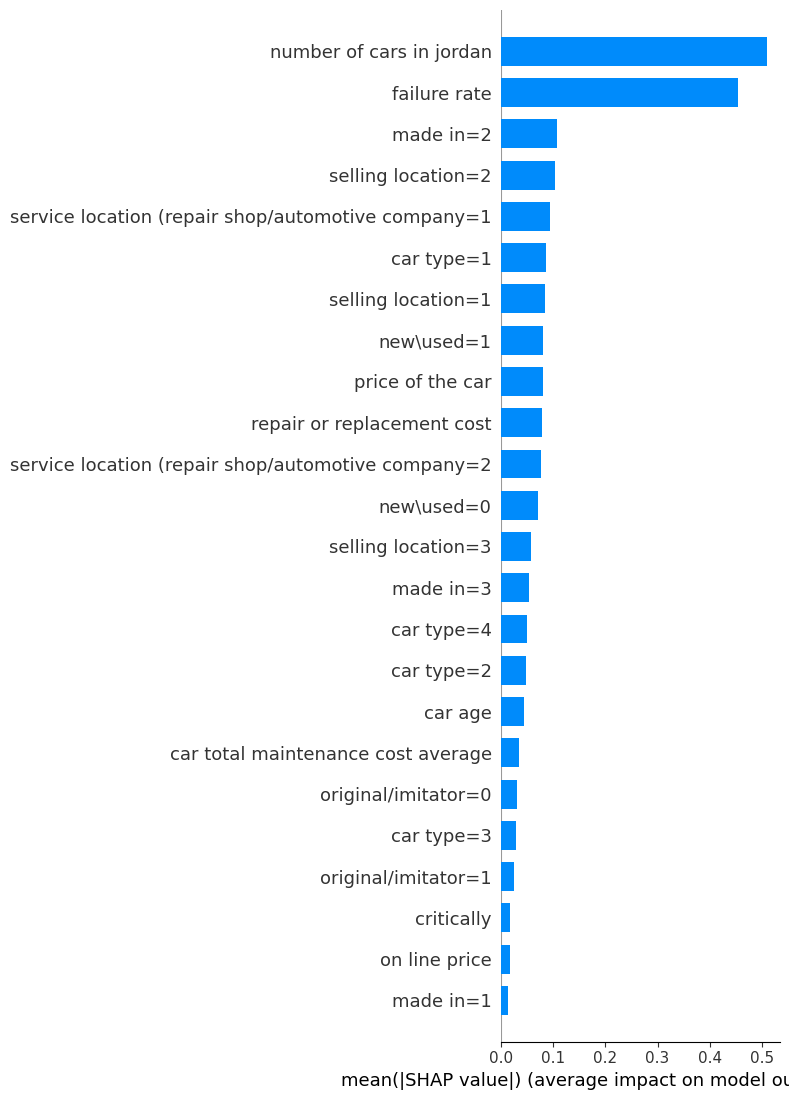

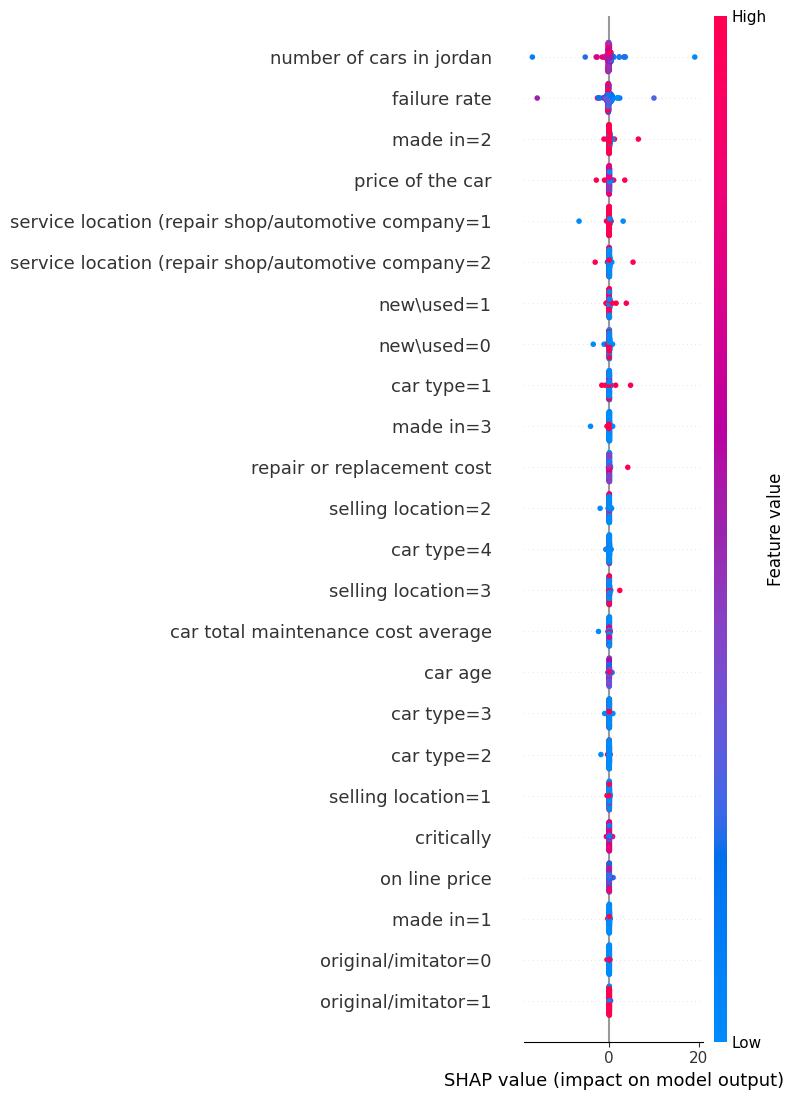

Saved SHAP beeswarm and top-20 CSV for low_demand


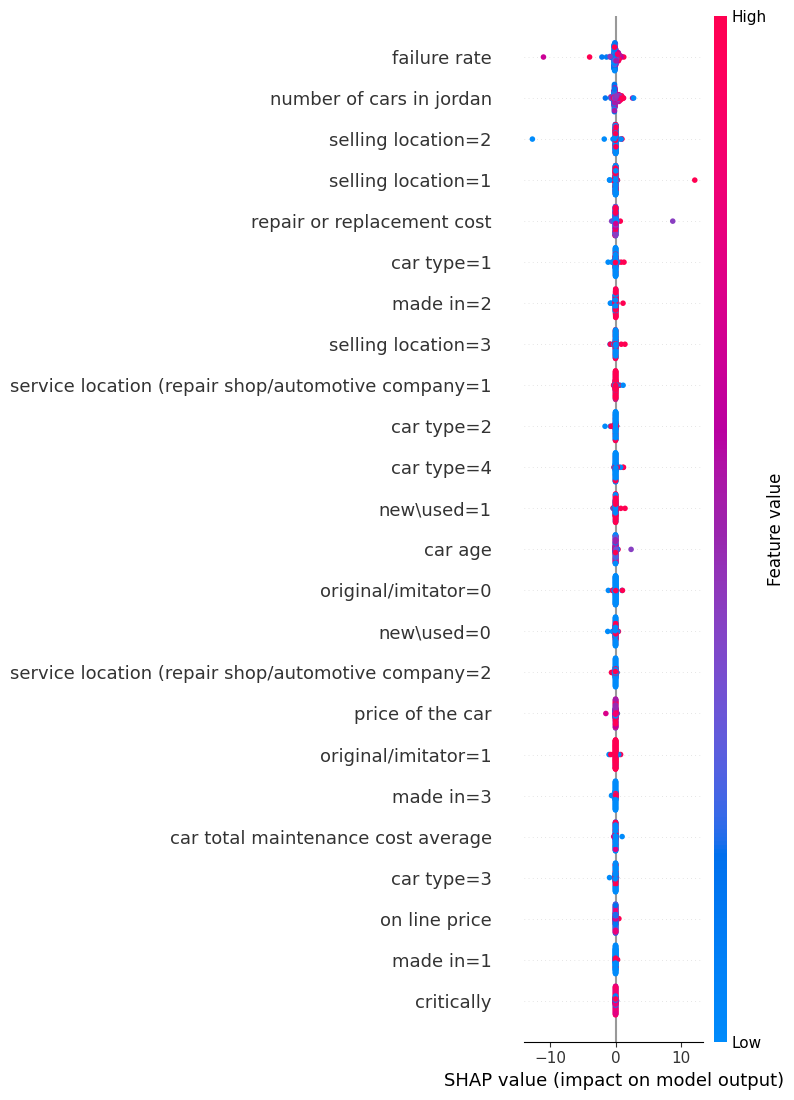

Saved SHAP beeswarm and top-20 CSV for high_demand
Saved: shap_summary_bar.png, shap_feature_importance_top20.csv plus class-specific outputs


In [40]:
# Generate summary plots and export top feature importances
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sv_raw = _shap_values
X_explain = _X_explain.toarray() if hasattr(_X_explain, 'toarray') else _X_explain

if isinstance(sv_raw, list):
    shap_array = np.stack([np.array(s) for s in sv_raw], axis=-1)
else:
    shap_array = np.array(sv_raw)
    if shap_array.ndim == 2:
        shap_array = shap_array[..., np.newaxis]

_shap_array = shap_array  # cache full tensor for later use
shap_abs = np.abs(shap_array).mean(axis=-1)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_abs, X_explain, feature_names=feature_names, plot_type='bar', show=False, max_display=25)
plt.tight_layout()
plt.savefig('shap_summary_bar.png', dpi=300, bbox_inches='tight')
plt.show()

class_order = globals().get('class_order', list(range(shap_array.shape[-1])))
class_indices = {cls: idx for idx, cls in enumerate(class_order) if idx < shap_array.shape[-1]}
target_classes = {
    'low_demand': 0,
    'high_demand': 2,
}

for label, cls_id in target_classes.items():
    if cls_id not in class_indices:
        continue
    cls_idx = class_indices[cls_id]
    shap_class = shap_array[..., cls_idx]

    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_class, X_explain, feature_names=feature_names, show=False, max_display=25)
    plt.tight_layout()
    plt.savefig(f'shap_beeswarm_{label}.png', dpi=300, bbox_inches='tight')
    plt.show()

    vals_cls = np.abs(shap_class).mean(axis=0)
    fi_cls = pd.Series(vals_cls, index=feature_names).sort_values(ascending=False)
    fi_cls.head(20).to_csv(f'shap_feature_importance_{label}_top20.csv')
    print(f'Saved SHAP beeswarm and top-20 CSV for {label}')

vals = shap_abs.mean(axis=0)
fi = pd.Series(vals, index=feature_names).sort_values(ascending=False)
fi.head(20).to_csv('shap_feature_importance_top20.csv')
print('Saved: shap_summary_bar.png, shap_feature_importance_top20.csv plus class-specific outputs')